# Time Series Generative Adversarial Networks

In [1]:
# Pacakge Loading
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from training import build_and_train_models
from utils import create_latent
from data import data_loading
import numpy as np

2023-07-19 15:54:04.372165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Data Preprocessing
# proxy_name = pd.read_csv('ProxyInstruments.csv')
# todo: ultimate goal is to incorporate all the proxy instruments?
# todo: returns was used as features instead of directly simulating the return series
# todo: need all the asset classes?
proxy_price = pd.read_csv('ProxyAdjPrices.csv', index_col=0, parse_dates=True)
proxy_price.interpolate(method='linear', inplace=True)

# Cash: FTSE 3 Month T-Bill Index, US Equity: S&P 500 TR, US Bond: Bloomberg US Aggregate Bond Index, Real Asset: S&P RA TR, Emerging Market: M2EF Index, Commodities: Bloomberg Commodity TR
Proxy_col=['SBMMTB3 Index', 'ACWI US Equity', 'LBUSTRUU Index', 'FNRETR Index', 'M2EF Index', 'BCOMTR Index']
data = proxy_price.loc[:, Proxy_col]
data = data.loc['2013-01-01':'2018-12-31', :] # return was not used as series directly since the original paper has one feature highly relient on return. Return was incorporated in the feature engineering process.

# data = data.pct_change().dropna()
# data from 2014-01-01 to 2018-12-31, training data from 2014-01-01 to 2017-12-31, testing data from 2018-01-01 to 2018-12-31
# split_date = '2018-01-01'
# train_data = data.loc[:split_date, :]
# test_data = data.loc[split_date:, :]

In [3]:
import torch
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: combine_sample
def combine_sample(real:torch.Tensor, fake:torch.Tensor, p_real):
    '''
    Function to take a set of real and fake images of the same length (x)
    and produce a combined tensor with length (x) and sampled at the target probability
    Parameters:
        real: a tensor of real images, length (x)
        fake: a tensor of fake images, length (x)
        p_real: the probability the images are sampled from the real set
    '''
    #### START CODE HERE ####
    # generate a vector of bernoulli random variables
    # with probability p_real
    # of length len(real)
    # hint: you can use torch.bernoulli() to generate the vector
    # note: you can use .to(device) to move a tensor to the GPU if available
    # bernoulli_rvs = torch.bernoulli(torch.Tensor(len(real)).uniform_(0,1))
    bernoulli_rvs = torch.bernoulli(torch.Tensor(len(real)).uniform_(0,1))
    # create a mask by filtering values of the random vector
    # greater than p_real
    # hint: you can use comparison operators to create a mask
    # note: you can use .to(device) to move a tensor to the GPU if available
    mask = bernoulli_rvs > p_real
    # create a combination of the real and fake images by
    # combining the images according to the mask
    # hint: you can use torch.where()
    # note: you can use .to(device) to move a tensor to the GPU if available
    target_images = torch.where(mask, real, fake)
    #### END CODE HERE ####
    return target_images

In [4]:
# Model Building
seq_length = 24 #specifying the length of series, multiple of 2 to make the reshape work
features_n = 6 #specifying the number of features
noise_dim = seq_length * features_n #specifying the dimension of noise vector
SHAPE = (seq_length, features_n) #specifying the shape of input data
hidden_dim = features_n * 4 #specifying the dimension of hidden layer

# todo: fine tune the hyperparameters & model structure
# Todo: interest rates,basic marcos, inflation, etc.
#
# bottoms up in unusual times.


# By saving the weights, it allows you to improve and retrain the model
"""
the original model used 2000 steps, here I just load a small number of steps
to highlight the process, and get the model architecture to load the weights into..
..if you want to retrain the model add more steps than 10 and don't load the weights.
"""
steps = 1000 # original model used 2000 (choose a low number if you)
gen0, gen1 = build_and_train_models(data = data, train_steps = steps, seq_length= seq_length, SHAPE= SHAPE)

# Comment and uncomment to load/save models
# gen1.save("gen0")
# gen0.save_weights("gen1_weights")

(array([1, 2, 3, 4, 5]), array([ 80, 902, 461,  89,   9]))
dataX.shape: (1541, 24, 7)
y.shape: (1541,)
y_train.shape: (1078, 6)
y_test.shape: (463, 6)
Model: "dis0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 discriminator0_input (InputLay  [(None, 144)]       0           []                               
 er)                                                                                              
                                                                                                  
 dense (Dense)                  (None, 144)          20880       ['discriminator0_input[0][0]']   
                                                                                                  
 dense_1 (Dense)                (None, 144)          20880       ['dense[0][0]']                  
                                           

/Users/huyifei/anaconda3/envs/GAN310/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-07-19 15:54:31.204981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 discriminator1_input (InputLay  [(None, 24, 6)]     0           []                               
 er)                                                                                              
                                                                                                  
 gru (GRU)                      (None, 144)          65664       ['discriminator1_input[0][0]']   
                                                                                                  
 reshape (Reshape)              (None, 12, 12)       0           ['gru[0][0]']                    
                                                                                                  
 conv1d (Conv1D)                (None, 6, 16)        592         ['reshape[0][0]']    

In [ ]:
# Data Visualization
# Todo: low variance in most of the proxy instruments, will this be a problem?

plt.plot(data['SBMMTB3 Index'], label='Cash')
plt.plot(data['ACWI US Equity'], label='US Equity')
plt.plot(data['LBUSTRUU Index'], label='US Bond')
plt.plot(data['FNRETR Index'], label='Real Asset')
plt.plot(data['M2EF Index'], label='Emerging Market')
plt.plot(data['BCOMTR Index'], label='Commodities')
plt.legend(loc='upper left')




In [ ]:
# Model Visualization
tf.keras.utils.plot_model(
    gen1, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB'
)

In [ ]:
# todo: conditional generation, maore layers to parametrize the price processes

from utils import inverse_trans
d_recipe = {}
d_recipe["class0"] = [0, True, "Normal"]
d_recipe["class5"] = [5, True, "Normal"]
d_recipe["noise"] = [None, False, "Normal"]
d_recipe["z0_4"] = [None, False, "z0_4"]
d_recipe["z1_4"] = [None, False, "z1_4"]
d_recipe["org"] = d_recipe["noise"]

key = 'class0'
datax, _, scaler = data_loading(seq_length, data)
# Generating Synthetic Data via GAN
new, noise_class, z0, z1 = create_latent(dataX = datax,batch_n=365, class_label = None, classed=False, noise="Normal")
gen0.compile(run_eagerly=True)
gen1.compile(run_eagerly=True)
feature0 = gen0.predict([noise_class, z1])
gen_data = gen1.predict([feature0, z0])
gen_data_t = inverse_trans(train_data= gen_data, scaler= scaler)

In [ ]:
# Generating Synthetic Data via GAN
print(gen_data_t[:,0,:].shape)
print(type(gen_data_t))
plt.plot(gen_data_t[:,0,3], label='Cash')

In [ ]:
cov_gan = np.cov(gen_data_t[:,0,:].T)
corr_gan = np.corrcoef(gen_data_t[:,0,:].T)
print('covariance matrix implied by GAN \n')
print(cov_gan)
print('\n correlation matrix implied by GAN\n')
print(corr_gan)

In [ ]:
# Generating Synthetic Data via Bootstrapping
from utils import bootstrap_from_historical
gen_data_b = bootstrap_from_historical(data, 365)
print(gen_data_b.shape)
cov_boot = np.cov(gen_data_b.T)
corr_boot = np.corrcoef(gen_data_b.T)
print('covariance matrix implied by Bootstrapping \n')
print(cov_boot)
print('\n correlation matrix implied by Bootstrapping \n')
print(corr_boot)

In [ ]:
# covaraince matrix implied by orignial data
cov_org = np.cov(data.T)
corr_org = np.corrcoef(data.T)
print('covariance matrix implied by original data \n')
print(cov_org)
print('\n correlation matrix implied by original data \n')
print(corr_org)


In [ ]:
# todo: implement conditional Generation
# d_recipe = {}
# d_recipe["class0"] = [0, True, "Normal"]
# d_recipe["class5"] = [5, True, "Normal"]
# d_recipe["noise"] = [None, False, "Normal"]
# d_recipe["z0_4"] = [None, False, "z0_4"]
# d_recipe["z1_4"] = [None, False, "z1_4"]
# d_recipe["org"] = d_recipe["noise"]

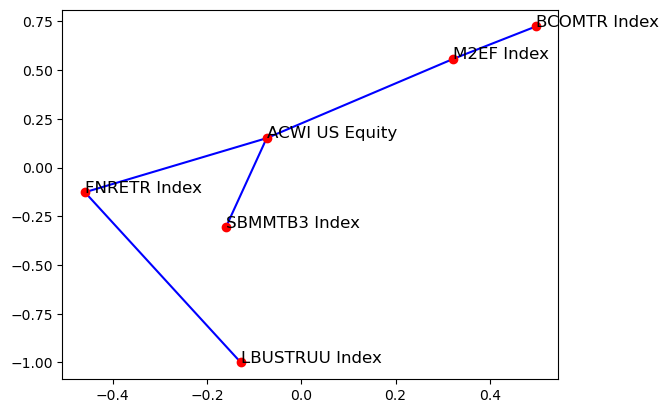

In [9]:
# Extracting Market Structure via MST from correlation matrix
# In this version, I will use the simple pearson correlation, while in later iterations, todo: ranked correlation will be tested for 1) stability of MST 2) implications for GAN training and portfolio construction

## Use index log return from 'Internship Data' as proxy for nodes.
# 1) Cash 2) commo


import networkx as nx
import matplotlib.pyplot as plt

# Creating the graph (edges with weights)
G = nx.Graph()
G.add_edge('A', 'B', weight=1)
G.add_edge('B', 'C', weight=2)
G.add_edge('A', 'C', weight=3)
G.add_edge('C', 'D', weight=4)

# Create MST using Kruskal's algorithm
T = nx.minimum_spanning_tree(G)

# Now draw the MST
pos = nx.spring_layout(T)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(T, pos, node_size=700)

# edges
nx.draw_networkx_edges(T, pos, width=6)

# labels
nx.draw_networkx_labels(T, pos, font_size=20, font_family='sans-serif')

plt.axis('off')
plt.show()


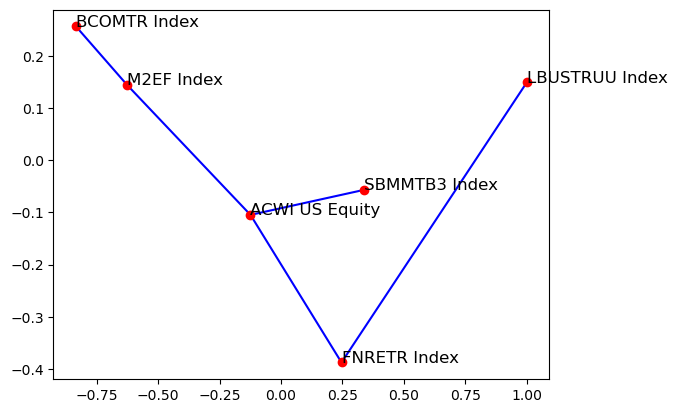